In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import datetime as dt
import os
from abc import abstractmethod

# Data preparation

In [2]:
def get_100_candles(ticker: str, tf: str, timestamp_ms_from: int):
    params = {
        'instId': ticker,
        'bar': tf,
        'after': timestamp_ms_from,
    }
    responce = requests.get('https://www.okx.com/api/v5/market/history-mark-price-candles', params)
    if not responce.ok:
        print('Bad request', responce.text)
        return
    candles = []
    for cs in json.loads(responce.text)['data']:
        candle = {
            'dt': dt.datetime.fromtimestamp(int(cs[0]) // 1000),
            'o': float(cs[1]),
            'h': float(cs[2]),
            'l': float(cs[3]),
            'c': float(cs[4]),
        }
        candles.append(candle)
    return candles

In [3]:
def get_timestamp_ms_range(from_date: dt.datetime, till_date: dt.datetime, delta: dt.timedelta):
    ts_range = []
    t = till_date
    while t > from_date:
        timestamp_ms = int(t.timestamp() * 1000)
        ts_range.append(timestamp_ms)
        t -= 100 * delta
    return ts_range

In [4]:
def get_candles_history(ticker: str, tf: str, from_date: dt.datetime, till_date: dt.datetime):
    """
    Get candlestick history of a ticker from OKX 
    """
    tf_to_timedelta = {
        '1D': dt.timedelta(days=1),
        '4H': dt.timedelta(hours=4),
    }
    candles = []
    ts_range = get_timestamp_ms_range(from_date, till_date, tf_to_timedelta[tf])
    for ts_ms in ts_range:
        new_candles = get_100_candles(ticker, tf, ts_ms)
        if new_candles:
            candles.extend(new_candles)
    if len(candles) == 0:
        return 
    df_candles = pd.DataFrame(candles).sort_values('dt')
    return df_candles[df_candles['dt'].between(from_date, till_date)].drop_duplicates('dt').reset_index(drop=True)

In [5]:
DATA_DIR = 'data'
DATA_FILENAME = 'crypto.csv'

path_to_data = os.path.join(DATA_DIR, DATA_FILENAME)
if not os.path.exists(path_to_data):
    tickers = ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT',
            'SOL-USDT', 'DOGE-TRX', 'TRX-USDT', 'LTC-USDT', 'TON-USDT',
            ]
    tf = '1D'
    date_from = dt.datetime(2020, 1, 1)
    date_till = dt.datetime(2025, 4, 1)
    data = []
    for ticker in tickers:
        print(ticker)
        ret = get_candles_history(ticker, tf, date_from, date_till)
        if ret is not None:
            ts = pd.Series(data=ret['c'].values, index=ret['dt'], name=ticker)
            data.append(ts)
    data = pd.concat(data, axis=1)
    data.to_csv(path_to_data)

data = pd.read_csv(path_to_data, index_col='dt', parse_dates=['dt'])
data.dropna(inplace=True)
data.sort_index(inplace=True)
print(data.shape)

(736, 9)


In [6]:
np.argmin(data.isna().sum(axis=1))

np.int64(0)

In [7]:
N = data.shape[1]
ASSET_NAMES = data.columns.tolist()

print('observations', data.shape[0])
print('from', data.index.min())
print('till', data.index.max())
print('ccys', ASSET_NAMES)

observations 736
from 2022-12-27 19:00:00
till 2024-12-31 19:00:00
ccys ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT', 'SOL-USDT', 'TRX-USDT', 'LTC-USDT', 'TON-USDT']


In [36]:
ret = data.diff(7) / data.shift(7)
ret.dropna(inplace=True)
ret.to_csv('data/returns.csv')
ret

,BTC-USDT,ETH-USDT,DOT-USDT,OKB-USDT,XRP-USDT,SOL-USDT,TRX-USDT,LTC-USDT,TON-USDT
dt,,,,,,,,,
2023-01-03 19:00:00,0.016653,0.055943,0.078490,0.174594,-0.026963,0.344460,0.017953,0.131493,0.083537
2023-01-04 19:00:00,0.013683,0.040196,0.055594,0.117705,-0.017099,0.417093,-0.009193,0.110464,0.040553
2023-01-05 19:00:00,0.017247,0.056698,0.088304,0.069087,-0.005211,0.377898,-0.036374,0.109112,0.034217
2023-01-06 19:00:00,0.020868,0.051423,0.067781,0.027579,0.002587,0.306488,-0.050605,0.083607,-0.013309
2023-01-07 19:00:00,0.026649,0.064812,0.095183,-0.020894,0.018316,0.406570,-0.034835,0.090702,-0.049956
...,...,...,...,...,...,...,...,...,...
2024-12-27 19:00:00,-0.031560,-0.006595,-0.024435,0.189876,-0.037772,0.018749,0.043164,-0.009336,0.081324
2024-12-28 19:00:00,-0.009079,0.021703,0.013931,0.110027,-0.024780,0.073090,0.067253,0.001392,0.063357
2024-12-29 19:00:00,-0.012196,0.014207,-0.036427,0.101556,-0.055569,0.035434,0.014137,-0.013042,0.019852


In [9]:
validation_mask = ret.index < dt.datetime(2024, 6, 30)
ret_validation = ret[validation_mask]
ret_test = ret[~validation_mask]
ret_validation.shape[0], ret_test.shape[0]

(544, 185)

# Hyperparameter optimization

In [10]:
class Strategy:
    @abstractmethod
    def fit(self, x_hist):
        pass
    def predict(self, x_hist):
        unit_sum = np.abs(self._w).sum()
        assert np.isclose(unit_sum, 1) or np.isclose(unit_sum, 0), f'weights sum={unit_sum: .2f}, {self.__cls__.__name__}, {self.to_dict()}'
        return self._w
    def to_dict(self):
        return self.__dict__
    def get_params(self):
        return {k:v for k, v in self.__dict__.items() if not k.startswith('_')}

class SingleAsset(Strategy):
    def __init__(self, idx):
        self.idx = idx
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        self._w = np.zeros((self._n, 1))
        self._w[self.idx] = 1

class Random(Strategy):
    def __init__(self, seed):
        self.seed = seed
        np.random.seed(self.seed)
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        w = np.random.randn(self._n, 1)
        w = w + np.abs(w).sum()
        w = w / w.sum()
        self._w = w

class Uniform(Strategy):
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        self._w = np.ones((self._n, 1)) / self._n

class Markowitz(Strategy):
    def __init__(self, minimal_return):
        super().__init__()
        self.minimal_return = minimal_return
    
    @abstractmethod
    def _mu_estimate(self, x_hist):
        pass
    def _cov_estimate(self, x_hist):
        return np.cov(x_hist, rowvar=False)
    def fit(self, x_hist):
        self._n = x_hist.shape[1]

        cov_hat = self._cov_estimate(x_hist)
        mu_hat = self._mu_estimate(x_hist)
        w, sol = self._min_var_fixed_mean(mu_hat, cov_hat, self.minimal_return)
        if sol.success:
            self._w = w.reshape((-1, 1))
            return 
        self._w = np.zeros((self._n, 1))
    def _min_var_fixed_mean(self, mu_hat, cov_hat, expected_return):
        n = mu_hat.shape[0]

        def objective(x):
            x = x.reshape((-1, 1))
            return x.T @ cov_hat @ x

        def unit_portfolio(x):
            return np.abs(x).sum() - 1
        
        def minimal_return(x):
            x = x.reshape((-1, 1))
            return x.T @ mu_hat - expected_return
        
        eq_cons = {
            'type': 'eq',
            'fun': unit_portfolio,
        }
        uneq_cons = {
            'type': 'ineq',
            'fun': minimal_return,
        }

        bounds = [(-1, 1) for i in range(n)]
        x0 = np.ones(n) / n

        sol = opt.minimize(
            fun=objective,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=[eq_cons, uneq_cons]
        )
        return sol.x.reshape((-1, 1)), sol
    
class Classic(Markowitz):
    def __init__(self, minimal_return, max_history_leng=None):
        super().__init__(minimal_return)
        self.max_history_leng = max_history_leng
    def _mu_estimate(self, x_hist):
        if self.max_history_leng is not None:
            x_hist = x_hist[-self.max_history_leng:, :]
        return x_hist.mean(axis=0)

class Martingal(Markowitz):
    def _mu_estimate(self, x_hist):
        return x_hist[-1, :]
    
class AntiMartingal(Markowitz):
    def _mu_estimate(self, x_hist):
        return -x_hist[-1, :]

In [11]:
def timeseries_split(df:pd.DataFrame, input_width:int=14, offset:int=7):
    size = df.shape[0]
    total_width = input_width + offset
    for i in range(size - total_width):
        x_hist = df.iloc[:i+input_width].values
        x_future = df.iloc[i + total_width].values.reshape((1, -1))
        yield i, x_hist, x_future

In [12]:
def test_strategy(strategy, ret):
    """
    Test single strategy
    """
    rois = []
    for i, x_hist, x_future in timeseries_split(ret):
        try:
            strategy.fit(x_hist)
        except Exception as e:
            print(f'{i}\n', e)
            continue
        w_pred = strategy.predict(x_hist)
        roi = (x_future @ w_pred).item()
        rois.append(roi)
    return np.array(rois)

In [13]:
def test_strategy_class(strategies, ret):
    """
    Run test for list of strategies with common set of params
    """
    report = []
    for strategy in strategies:
        rois = test_strategy(strategy, ret)
        report_item = dict()
        report_item.update(strategy.get_params())
        report_item['mean_roi'] = rois.mean().item()
        report_item['std_roi'] = rois.std().item()
        report_item['n_tests'] = len(rois)
        report_item['winrate'] = (rois > 0).mean().item()
        report.append(report_item)
    return pd.DataFrame(report)


In [14]:
classic_strategies = [
    Classic(mr, mhl)
    for mr in np.linspace(0.01, 0.1, 10).tolist()
    for mhl in np.arange(5, 50, 5).tolist() + [None]
]
classic_report = test_strategy_class(classic_strategies, ret_validation.tail(30))
classic_report.to_csv('results/classic_strategies.csv', index=False)

10


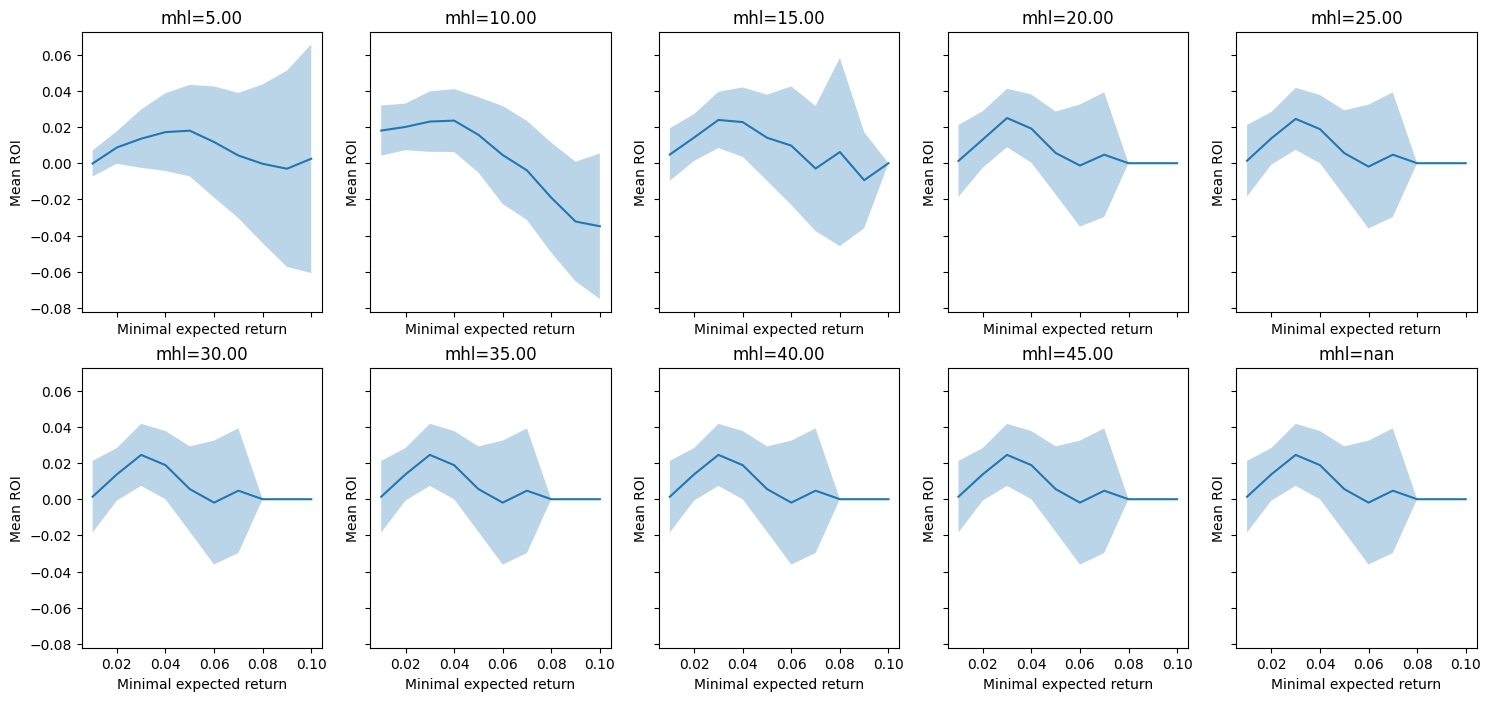

In [15]:
mhl_list = classic_report['max_history_leng'].unique()
print(len(mhl_list))
fig, axs = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
for ax, mhl in zip(axs.flatten(), mhl_list):
    df = classic_report[classic_report['max_history_leng'] == mhl]
    if df.shape[0] == 0:
        df = classic_report[classic_report['max_history_leng'].isna()]
    ax.plot(df['minimal_return'], df['mean_roi'])
    ax.fill_between(df['minimal_return'], df['mean_roi'] - df['std_roi'], df['mean_roi'] + df['std_roi'], alpha=0.3)
    ax.set_title(f'mhl={mhl:.2f}')
    ax.set_xlabel('Minimal expected return')
    ax.set_ylabel('Mean ROI')

In [16]:
classic_report.sort_values(['winrate', 'mean_roi'], ascending=False)

,minimal_return,max_history_leng,mean_roi,std_roi,n_tests,winrate
23,0.03,20.0,0.024990,0.016158,9,1.0
22,0.03,15.0,0.023920,0.015557,9,1.0
11,0.02,10.0,0.020069,0.012880,9,1.0
12,0.02,15.0,0.014203,0.012943,9,1.0
14,0.02,25.0,0.013753,0.014527,9,1.0
...,...,...,...,...,...,...
97,0.10,40.0,0.000000,0.000000,9,0.0
98,0.10,45.0,0.000000,0.000000,9,0.0
99,0.10,NaN,0.000000,0.000000,9,0.0
82,0.09,15.0,-0.009400,0.026587,9,0.0


In [17]:
martingal_strategies = [
    Martingal(mr)
    for mr in np.linspace(0.01, 0.1, 10).tolist()
]
martingal_report = test_strategy_class(martingal_strategies, ret_validation.tail(30))
martingal_report.to_csv('results/martingal_strategies.csv', index=False)

Text(0, 0.5, 'Mean ROI')

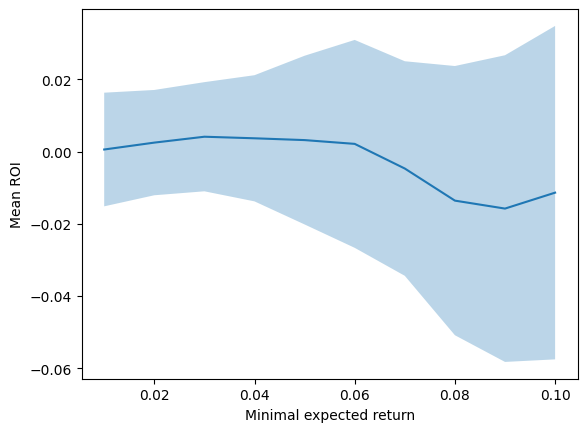

In [18]:
plt.plot(martingal_report['minimal_return'], martingal_report['mean_roi'])
plt.fill_between(martingal_report['minimal_return'], martingal_report['mean_roi'] - martingal_report['std_roi'], martingal_report['mean_roi'] + martingal_report['std_roi'], alpha=0.3)
plt.xlabel('Minimal expected return')
plt.ylabel('Mean ROI')

In [19]:
single_asset_strategies = [
    SingleAsset(i)
    for i in range(ret.shape[1])
]
single_asset_report = test_strategy_class(single_asset_strategies, ret_validation)
single_asset_report.to_csv('results/single_asset_strategies.csv', index=False)
single_asset_report

,idx,mean_roi,std_roi,n_tests,winrate
0,0,0.016098,0.070052,523,0.537285
1,1,0.012637,0.072109,523,0.516252
2,2,0.004038,0.093504,523,0.478011
3,3,0.006092,0.083832,523,0.458891
4,4,0.006333,0.098123,523,0.483748
5,5,0.032746,0.135293,523,0.527725
6,6,0.010454,0.046641,523,0.632887
7,7,0.001094,0.084942,523,0.487572
8,8,0.021869,0.112675,523,0.520076


Text(0, 0.5, 'Mean ROI')

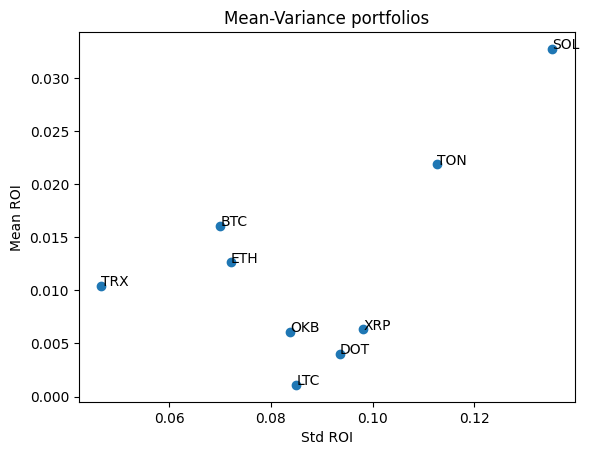

In [20]:
plt.scatter(single_asset_report['std_roi'], single_asset_report['mean_roi'])
for i, row in single_asset_report.iterrows():
    plt.annotate(ASSET_NAMES[i].split('-')[0], (row['std_roi'], row['mean_roi']))
plt.title('Mean-Variance portfolios')
plt.xlabel('Std ROI')
plt.ylabel('Mean ROI')

# Логирование результатов

In [34]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
classic_params = {
    'minimal_return': np.linspace(0, 0.15, 21).tolist(),
    'max_history_leng': np.arange(5, 50, 5).tolist() + [100],
}


{'minimal_return': [0.0,
  0.0075,
  0.015,
  0.0225,
  0.03,
  0.0375,
  0.045,
  0.0525,
  0.06,
  0.0675,
  0.075,
  0.08249999999999999,
  0.09,
  0.0975,
  0.105,
  0.11249999999999999,
  0.12,
  0.1275,
  0.135,
  0.1425,
  0.15],
 'max_history_leng': [5, 10, 15, 20, 25, 30, 35, 40, 45, 100]}

# Сравнение лучших стратегий

In [21]:
best_strategies = {
    'classic': classic_strategies[23],
    'martingal': martingal_strategies[0],
    'antimartingal': AntiMartingal(0.05),
    'random': Random(27),
    'uniform': Uniform(),
    'btc': SingleAsset(0),
    'xrp': SingleAsset(4),
}
rois_result = {}
for name, strategy in best_strategies.items():
    rois = test_strategy(strategy, ret_test)
    rois_result[name] = rois
rois_result = pd.DataFrame(rois_result)
rois_result.tail()

,classic,martingal,antimartingal,random,uniform,btc,xrp
159,0.022411,-0.047387,0.051560,0.024746,0.024824,-0.031560,-0.037772
160,-0.002974,-0.026323,0.039213,0.034861,0.035210,-0.009079,-0.024780
161,-0.002953,-0.020363,0.031287,0.007895,0.007550,-0.012196,-0.055569
162,0.001982,-0.015820,0.015392,-0.032405,-0.030564,-0.029430,-0.083172
163,0.010575,-0.025432,0.011255,-0.036066,-0.035001,-0.041456,-0.022463


In [22]:
stats = pd.DataFrame()
stats['mean_roi'] = rois_result.mean(axis=0)
stats['std_roi'] = rois_result.std(axis=0)
stats['VaR_95'] = np.quantile(rois_result, 0.05, axis=0)
stats['total_pnl'] = rois_result.sum(axis=0)
stats['winrate'] = (rois_result > 0).mean(axis=0)
stats

,mean_roi,std_roi,VaR_95,total_pnl,winrate
classic,-0.003377,0.040898,-0.053958,-0.553878,0.335366
martingal,-0.004624,0.028678,-0.055719,-0.758339,0.457317
antimartingal,0.006035,0.043645,-0.048192,0.989688,0.548780
random,0.020651,0.092662,-0.114580,3.386838,0.554878
uniform,0.020424,0.092257,-0.114097,3.349481,0.560976
btc,0.018416,0.070303,-0.078576,3.020238,0.621951
xrp,0.076608,0.224827,-0.122932,12.563742,0.560976


In [23]:
tau_range = np.linspace(0, 0.1, 10).tolist()

curves = [
    test_strategy_class([Classic(t, 45) for t in tau_range] , ret_test.tail(100)),
    test_strategy_class([Martingal(t) for t in tau_range] , ret_test.tail(100)),
    test_strategy_class([AntiMartingal(t) for t in tau_range] , ret_test.tail(100)),
]

for curve in curves:
    plt.plot(curve['std_roi'], curve['mean_roi'], marker='o')

plt.scatter(stats['std_roi'], stats['mean_roi'])
for i, row in stats.iterrows():
    plt.annotate(i, (row['std_roi'], row['mean_roi']))
plt.title('Mean-Variance portfolios')
plt.xlabel('Std ROI')
plt.ylabel('Mean ROI')

KeyboardInterrupt: 

Text(0, 0.5, 'Mean ROI')

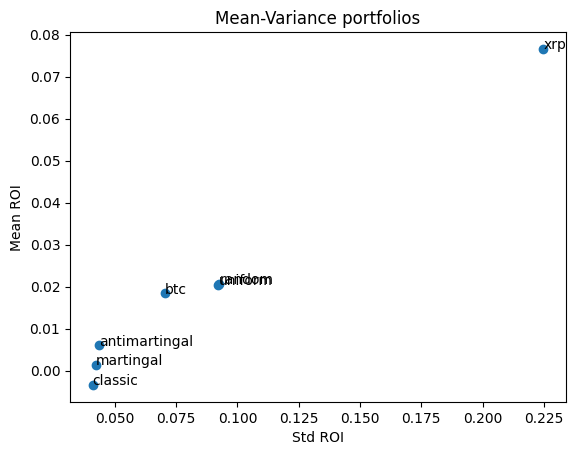

In [315]:
plt.scatter(stats['std_roi'], stats['mean_roi'])
for i, row in stats.iterrows():
    plt.annotate(i, (row['std_roi'], row['mean_roi']))
plt.title('Mean-Variance portfolios')
plt.xlabel('Std ROI')
plt.ylabel('Mean ROI')

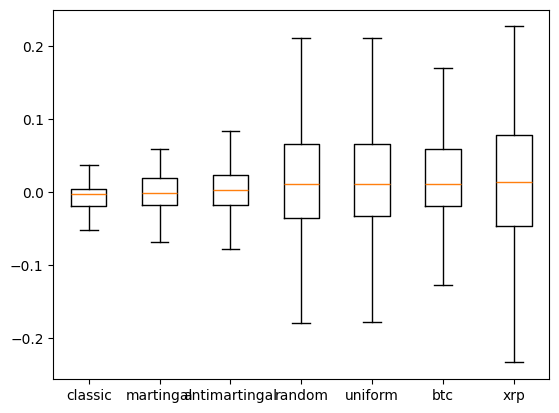

In [316]:
plt.boxplot(rois_result, tick_labels=rois_result.columns, showfliers=False)
plt.show()

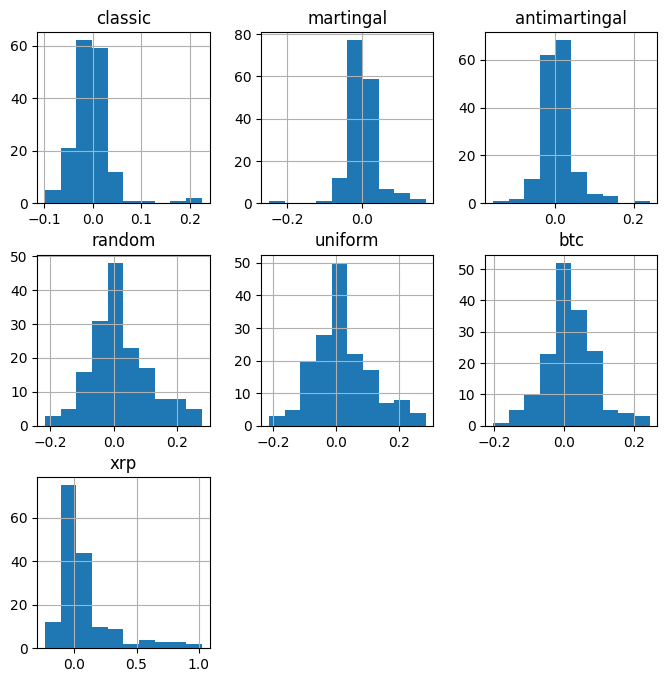

In [317]:
rois_result.hist(figsize=(8, 8))
plt.title('ROI distribution')
plt.show()